In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

%matplotlib inline

In [36]:
def filterDataset(data):
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

In [35]:
def train_and_test():
    #load and filter data
    data = pd.read_csv('processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    data = filterDataset(data)
   
    ## split data into train and test
    cols = list(data.columns)
    cols.remove('num')
    target = data['num'].copy()
    input_data = data[cols].copy()
    target_bin = label_binarize(target, classes=[0, 1, 2, 3, 4])
    #test removing healthy patients
    #target_bin = label_binarize(target, classes=[1, 2, 3, 4])
    
    global targetTests
    dTrain, dTest, targetTrain, targetTest = train_test_split(input_data, target_bin, test_size=0.25, stratify=target_bin)
    targetTests.append(targetTest)
    
    scaler = preprocessing.StandardScaler().fit(dTrain)
    dTrain = scaler.transform(dTrain)
    
    #svm
    ovr = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0), n_jobs=-1)
    ovr.fit(dTrain, targetTrain)
    
    #predicting
    dTest = scaler.transform(dTest)
    probas = ovr.predict_proba(dTest)
    pred = ovr.predict(dTest)
    score = ovr.score(dTest, targetTest)
    targetTest_nonbin = np.asarray(np.argmax(targetTest, axis=1))
    #print(targetTest_nonbin)
    pred = np.asarray(np.argmax(pred, axis=1))
    cm = confusion_matrix(targetTest_nonbin, pred, labels=[0,1,2,3,4])
    #test removing healthy patients
    #cm = confusion_matrix(targetTest_nonbin, pred, labels=[1,2,3,4])
    #score = np.sum(np.diagonal(cm))/np.sum(cm)
    np.savetxt("confusion_matrix_ova.csv", cm, delimiter=",")
    
    return score, probas

In [41]:
targetTests = []
scores = []
probas_final = []
iterations = 50
for i in tqdm(range(iterations)):
    score, probas = train_and_test()
    scores.append(score)
    probas_final.append(probas)
    #y_score_final += y_score

#use the target split related to the best accuracy
target = targetTests[np.argmax(scores)]
proba = probas_final[np.argmax(scores)]
scores = np.asarray(scores)
print("best: ", np.max(scores))
print("avg: ", scores.mean())
print("std: ", scores.std())

100%|██████████| 50/50 [00:10<00:00,  4.90it/s]      | 1/50 [00:00<00:11,  4.37it/s]

best:  0.48
avg:  0.366133333333
std:  0.0697530883426


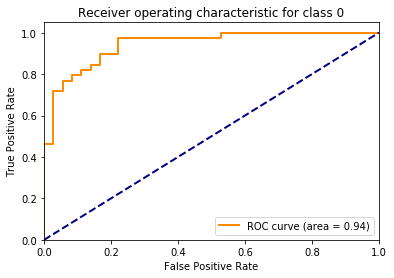

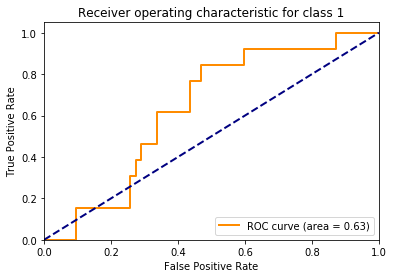

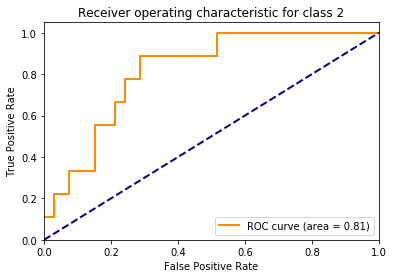

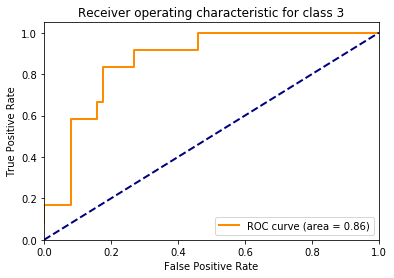

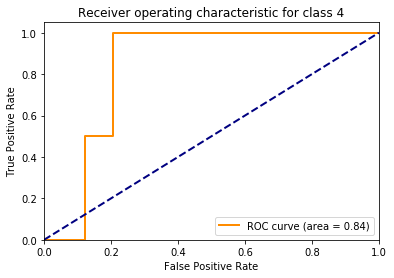

In [42]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#for i in range(5):
#test removing healthy patients
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(target[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#for i in range(5):
#test removing healthy patients
for i in range(5):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(i))
    plt.legend(loc="lower right")

    plt.show()


In [39]:
ova = pd.read_csv('confusion_matrix_ova.csv', header=None)
print(ova)

      0    1    2    3    4
0  36.0  2.0  1.0  0.0  1.0
1   5.0  7.0  1.0  0.0  0.0
2   1.0  8.0  5.0  0.0  0.0
3   0.0  5.0  2.0  0.0  1.0
4   0.0  0.0  0.0  0.0  0.0
